In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Due to the problem's nature, try to create features that give an idea of the location 
# of passengers during the abnormality

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")


print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print(df_train.columns)
print()
null_values_per_column = df_train.isnull().sum()
print(null_values_per_column)

print()
print(df_train.describe())
print()

print()
print(df_train.dtypes)
print()
# HomePlanet Feature
print("HomePlanet uniques:", df_train["HomePlanet"].unique())
n_HomePlanet_uniques = df_train["HomePlanet"].unique().shape[0]
print("HomePlanet unique count:", n_HomePlanet_uniques)

# Cabin Feature
print("Cabin uniques:", df_train["Cabin"].unique())
n_Cabin_uniques = df_train["Cabin"].unique().shape[0]
print("Cabin unique count:", n_Cabin_uniques)

# Destination Feature
print("Destination uniques:", df_train["Destination"].unique())
n_Destination_uniques = df_train["Destination"].unique().shape[0]
print("Destination unique count:", n_Destination_uniques)
print()

# Attention to 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' features,
# they looks like to have many outliers

# Null values
df_train = df_train.dropna() # Only for now

indexes = df_train.index
n = df_train.shape[0]

Train shape: (8693, 14)
Test shape: (4277, 13)
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000

# Group Size

Size 1 | Transported Rate = 0.4638149714001492
Size 2 | Transported Rate = 0.5443037974683544
Size 3 | Transported Rate = 0.5900709219858156
Size 4 | Transported Rate = 0.6129032258064516
Size 5 | Transported Rate = 0.5764705882352941
Size 6 | Transported Rate = 0.5333333333333333
Size 7 | Transported Rate = 0.6
Size 8 | Transported Rate = 0.25
GroupSize
0    4021
1    2217
2     368
Name: count, dtype: int64


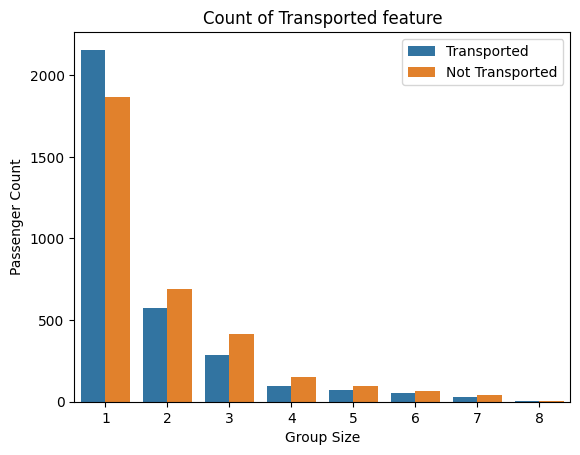

In [89]:
df_copy = df_train.copy()
df_copy["PassengerId"] = df_copy["PassengerId"].apply(lambda x: int(x[:4]))
values_frequency = df_copy["PassengerId"].value_counts()
df_copy["GroupSize"] = df_copy["PassengerId"].apply(lambda x: values_frequency.loc[x])

for i in range(1,9):
    group_i = df_copy[df_copy["GroupSize"] == i ]
    transported_i = group_i[ group_i["Transported"] == True ]
    print("Size {} | Transported Rate = {}".format( i , transported_i.shape[0] / group_i.shape[0] ))

ax = sns.countplot(x='GroupSize', hue='Transported', data=df_copy)
plt.xlabel('Group Size')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")

def final_categories(x):
    if x == 1: 
        return 0 # Singular "group"

    elif x <= 4:
        return 1 # Medium group

    else:
        return 2 # Big group
        
df_train["GroupSize"] = df_copy["GroupSize"].apply(final_categories)
print(df_train["GroupSize"].value_counts())

# Analysing: Home -> Destination 

In [90]:
df_groupby = df_train.groupby(by = ["HomePlanet", "Destination"])
groupby_comparation = pd.DataFrame()
for i in df_groupby:
    home_destination = i[0][0]+"_"+i[0][1]
    HD_df = i[1]

    isHP_column = (df_train["HomePlanet"] == i[0][0]) & (df_train["Destination"] == i[0][1])
    df_train[home_destination] = isHP_column

    n_HD = HD_df.shape[0]
    transported_HD = HD_df[HD_df["Transported"]==True].shape[0]

    groupby_comparation[home_destination] = [transported_HD / n_HD]
groupby_comparation.index = ["Transported rate"]
print(groupby_comparation.T)

print()
print(df_train.head())

                      Transported rate
Earth_55 Cancri e             0.528986
Earth_PSO J318.5-22           0.503521
Earth_TRAPPIST-1e             0.384301
Europa_55 Cancri e            0.694168
Europa_PSO J318.5-22          0.764706
Europa_TRAPPIST-1e            0.632739
Mars_55 Cancri e              0.631579
Mars_PSO J318.5-22            0.421053
Mars_TRAPPIST-1e              0.503823

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall  ...  GroupSize  Earth_55 Cancri e  \
0          0.0        0.0           0.0  ...          0              False   
1        109.0        9.0 

# Analysing: Cabin

In [91]:
df_copy = df_train.copy()
df_copy["Cabin"] = df_copy["Cabin"].apply(lambda x: x[0] + x[-1])
df_groupby = df_copy.groupby(by = "Cabin")
groupby_comparation = pd.DataFrame()
for i in df_groupby:
    cabin = i[0][0]+"_"+i[0][1]
    cabin_df = i[1]

    iscabin_column = (df_train["Cabin"].apply(lambda x: x[0]) == i[0][0]) & (df_train["Cabin"].apply(lambda x: x[-1]) == i[0][1])
    df_train[cabin] = iscabin_column

    n_cabin = cabin_df.shape[0]
    transported_cabin = cabin_df[cabin_df["Transported"]==True].shape[0]

    groupby_comparation[cabin] = [transported_cabin / n_cabin]
groupby_comparation.index = ["Transported rate"]
print(groupby_comparation.T)

print(df_train.head())

     Transported rate
A_P          0.434783
A_S          0.530435
B_P          0.671329
B_S          0.777778
C_P          0.576336
C_S          0.763077
D_P          0.392857
D_S          0.455056
E_P          0.342424
E_S          0.373938
F_P          0.405797
F_S          0.466603
G_P          0.449949
G_S          0.592480
T_P          0.500000
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall  ...    C_S    D_P    D_S    E_P  \
0          0.0        0.0           0.0  ...  False  False  False  False   
1        109.0        9.0          25.0  ...  False  False  False  Fa

# Comparing Transported and Not Transported stats

In [92]:
# Comparing Transported and Not Transported dataframes
transported_df = df_train[ df_train["Transported"] == True ]
not_transported_df = df_train[ df_train["Transported"] == False ]

transported_stats = transported_df.describe()
not_transported_stats = not_transported_df.describe()

comparing_df = pd.DataFrame()
comparing_df["T Mean"] = transported_stats.loc["mean"]
comparing_df["NT Mean"] = not_transported_stats.loc["mean"]
comparing_df["T Std"] = transported_stats.loc["std"]
comparing_df["NT Std"] = not_transported_stats.loc["std"]

print(comparing_df)

                  T Mean     NT Mean        T Std       NT Std
Age            27.703036   30.102470    15.266569    13.646138
RoomService    64.658852  383.642269   282.632489   840.194088
FoodCourt     570.646829  385.928027  2028.337287  1218.965709
ShoppingMall  184.993989  171.621836   658.200425   479.178761
Spa            63.484521  566.493443   264.541400  1561.613357
VRDeck         71.105801  539.860323   294.972045  1536.525218
GroupSize       0.501353    0.391888     0.611511     0.580711


# Analysing the five money features

## RoomService

count    6606.000000
mean        4.550850
std        13.163019
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       202.448980
Name: RoomService, dtype: float64
RoomService
0    4318
2    2022
1     266
Name: count, dtype: int64


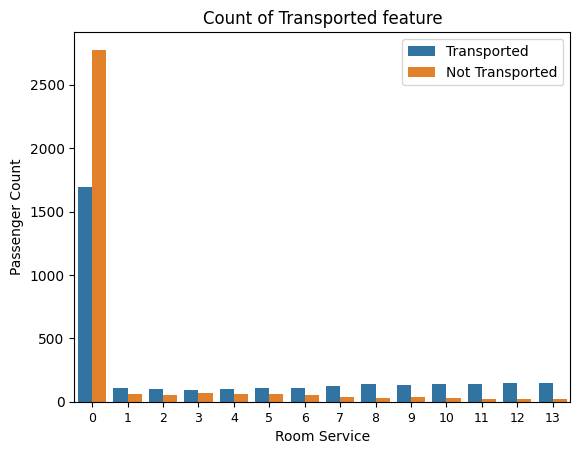

In [93]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["RoomService"] = scaler.fit_transform(np.array(df_copy["RoomService"]).reshape(-1,1))
print(df_copy["RoomService"].describe())
df_copy["RoomService"] = pd.qcut(df_copy["RoomService"], 40, duplicates = "drop")
all_intervals = df_copy["RoomService"].cat.categories


#df_copy["RoomService"] = pd.cut(df_copy["RoomService"], [-1, 0.01, 2.5, 250])

ax = sns.countplot(x='RoomService', hue='Transported', data=df_copy)
plt.xlabel('Room Service')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["RoomService"] = label_encoder.fit_transform(df_copy["RoomService"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 6:
        return 1

    else:
        return 2
        
df_train["RoomService"] = df_train["RoomService"].apply(final_categories)
print(df_train["RoomService"].value_counts())

## FoodCourt

count    6606.000000
mean        5.788018
std        20.285103
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       360.277946
Name: FoodCourt, dtype: float64
FoodCourt
0    4241
4    1938
1     349
2      54
3      24
Name: count, dtype: int64


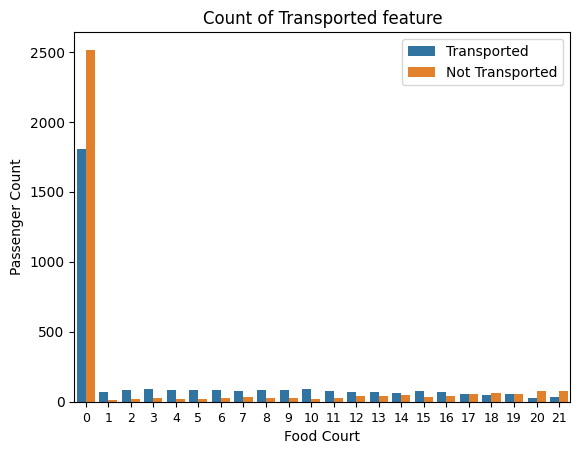

In [94]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["FoodCourt"] = scaler.fit_transform(np.array(df_copy["FoodCourt"]).reshape(-1,1))
print(df_copy["FoodCourt"].describe())
df_copy["FoodCourt"] = pd.qcut(df_copy["FoodCourt"], 60, duplicates = "drop")
all_intervals = df_copy["FoodCourt"].cat.categories



ax = sns.countplot(x='FoodCourt', hue='Transported', data=df_copy)
plt.xlabel('Food Court')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["FoodCourt"] = label_encoder.fit_transform(df_copy["FoodCourt"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 11:
        return 1

    elif x <= 16:
        return 2

    elif x <= 19:
        return 3
        
    else:
        return 4
        
df_train["FoodCourt"] = df_train["FoodCourt"].apply(final_categories)
print(df_train["FoodCourt"].value_counts())

## ShoppingMall  

count    6606.000000
mean        5.945216
std        19.210947
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       408.433333
Name: ShoppingMall, dtype: float64
ShoppingMall
0    4332
3    1741
1     480
2      53
Name: count, dtype: int64


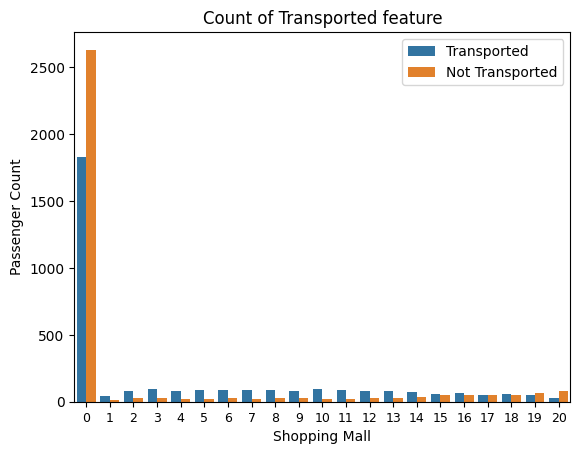

In [95]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["ShoppingMall"] = scaler.fit_transform(np.array(df_copy["ShoppingMall"]).reshape(-1,1))
print(df_copy["ShoppingMall"].describe())
df_copy["ShoppingMall"] = pd.qcut(df_copy["ShoppingMall"], 60, duplicates = "drop")
all_intervals = df_copy["ShoppingMall"].cat.categories



ax = sns.countplot(x='ShoppingMall', hue='Transported', data=df_copy)
plt.xlabel('Shopping Mall')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["ShoppingMall"] = label_encoder.fit_transform(df_copy["ShoppingMall"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 14:
        return 1

    elif x <= 18:
        return 2
        
    else:
        return 3
        
df_train["ShoppingMall"] = df_train["ShoppingMall"].apply(final_categories)
print(df_train["ShoppingMall"].value_counts())

## Spa

count    6606.000000
mean        4.817870
std        17.600251
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       344.738462
Name: Spa, dtype: float64
Spa
0    4109
4    1931
1     432
2      76
3      58
Name: count, dtype: int64


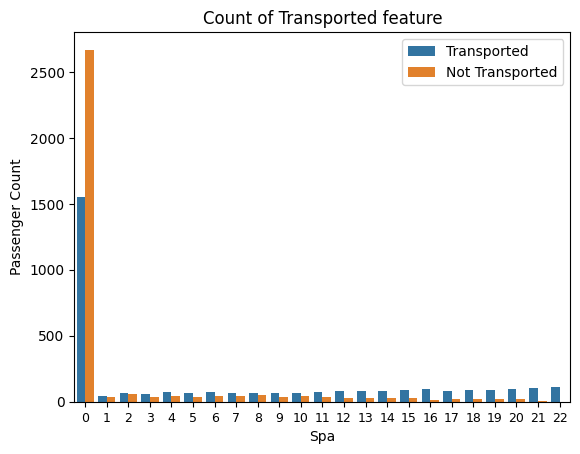

In [96]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["Spa"] = scaler.fit_transform(np.array(df_copy["Spa"]).reshape(-1,1))
print(df_copy["Spa"].describe())
df_copy["Spa"] = pd.qcut(df_copy["Spa"], 60, duplicates = "drop")
all_intervals = df_copy["Spa"].cat.categories



ax = sns.countplot(x='Spa', hue='Transported', data=df_copy)
plt.xlabel('Spa')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["Spa"] = label_encoder.fit_transform(df_copy["Spa"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 10:
        return 1

    elif x <= 15:
        return 2

    elif x <= 20:
        return 3
        
    else:
        return 4
        
df_train["Spa"] = df_train["Spa"].apply(final_categories)
print(df_train["Spa"].value_counts())

## VRDeck

count    6606.000000
mean        5.841924
std        21.675811
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       391.076923
Name: VRDeck, dtype: float64
VRDeck
0    4241
3    1857
1     451
2      57
Name: count, dtype: int64


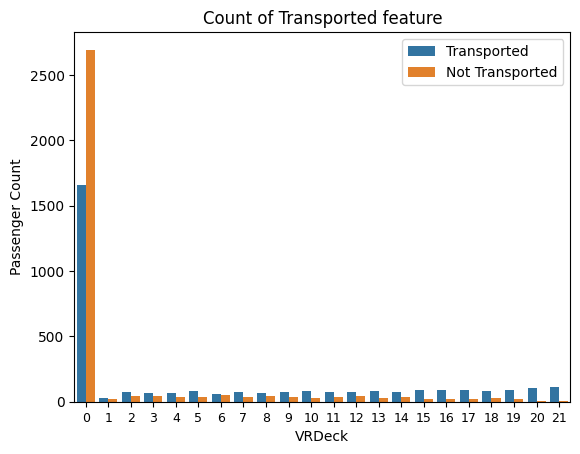

In [97]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["VRDeck"] = scaler.fit_transform(np.array(df_copy["VRDeck"]).reshape(-1,1))
print(df_copy["VRDeck"].describe())
df_copy["VRDeck"] = pd.qcut(df_copy["VRDeck"], 60, duplicates = "drop")
all_intervals = df_copy["VRDeck"].cat.categories



ax = sns.countplot(x='VRDeck', hue='Transported', data=df_copy)
plt.xlabel('VRDeck')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["VRDeck"] = label_encoder.fit_transform(df_copy["VRDeck"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 14:
        return 1

    elif x <= 19:
        return 2
        
    else:
        return 3
        
df_train["VRDeck"] = df_train["VRDeck"].apply(final_categories)
print(df_train["VRDeck"].value_counts())

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'GroupSize', 'Earth_55 Cancri e',
       'Earth_PSO J318.5-22', 'Earth_TRAPPIST-1e', 'Europa_55 Cancri e',
       'Europa_PSO J318.5-22', 'Europa_TRAPPIST-1e', 'Mars_55 Cancri e',
       'Mars_PSO J318.5-22', 'Mars_TRAPPIST-1e', 'A_P', 'A_S', 'B_P', 'B_S',
       'C_P', 'C_S', 'D_P', 'D_S', 'E_P', 'E_S', 'F_P', 'F_S', 'G_P', 'G_S',
       'T_P'],
      dtype='object')

Transported             1.000000
CryoSleep               0.462803
Europa_55 Cancri e      0.131509
B_S                     0.128118
C_S                     0.118035
Europa_TRAPPIST-1e      0.106021
GroupSize               0.091395
G_S                     0.074342
B_P                     0.071349
Mars_55 Cancri e        0.039271
C_P                     0.029550
Europa_PSO J318.5-22    0.026523
Earth_55 Cancri e       0.015311
A_S                     0.007135
Mars_TRAPPIST-1e        0.000177
Earth_PSO J318.5

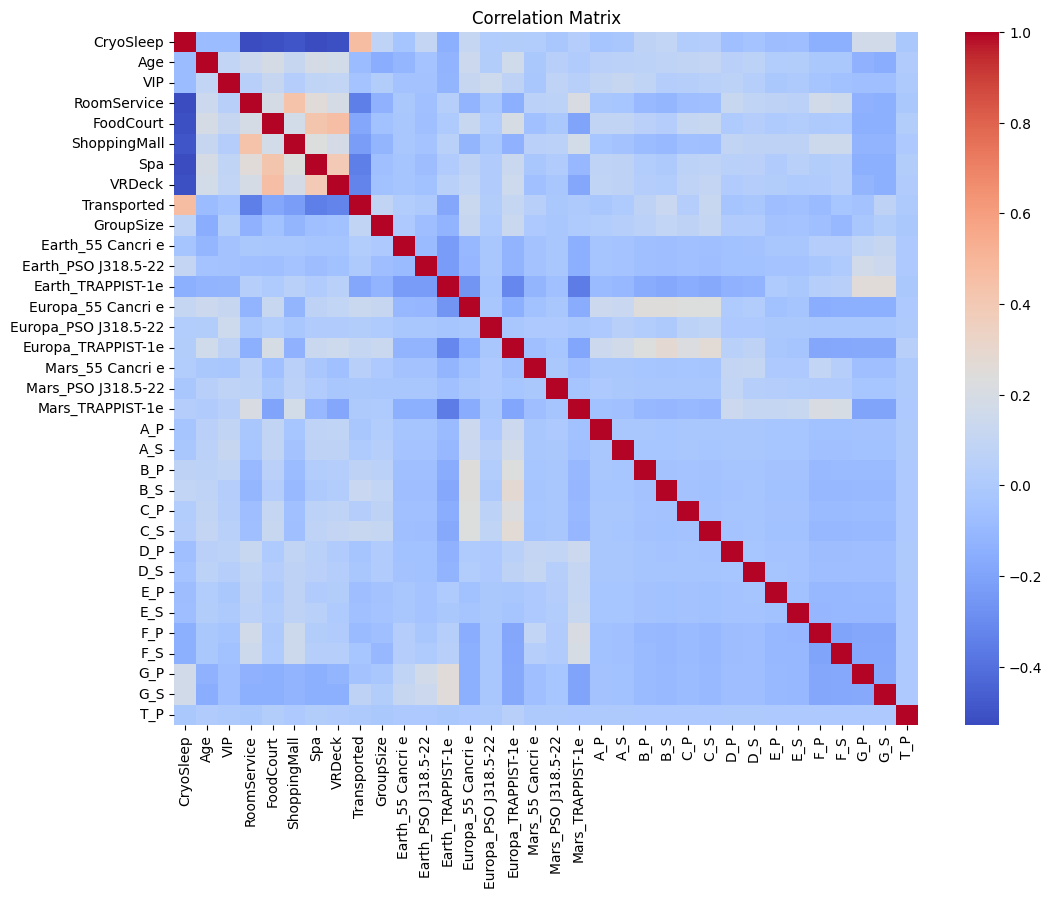

In [99]:
correlation_df = df_train.copy()
correlation_df = correlation_df.drop(columns = ["PassengerId", "HomePlanet", "Cabin", "Destination", "Name"])
print(correlation_df.columns)
print()
correlation_matrix = correlation_df.corr()
print(correlation_matrix["Transported"].sort_values(ascending = False).T)

plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', annot_kws={"size": 12})
plt.title('Correlation Matrix')
plt.show()


